In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import cm
%run -i pltparams.py

In [2]:
#define functions to add in the data columns we want
def offset_rentBurden(df):
    #for the percRealWageChange calculation, we need the preceding year's rent burden. So making this pd Series which just offsets the rentBuden column by one row
    rB = df["rentBurden"].to_numpy()
    rB = np.concatenate([[0], rB])
    rB = rB[:-1]
    rentBurden_offset = pd.Series(rB)
    return rentBurden_offset
def offset_wages(df):
    rB = df["wages"].to_numpy()
    rB = np.concatenate([[0], rB])
    rB = rB[:-1]
    wages_offset = pd.Series(rB)
    return wages_offset


def add_columns(camp_data, wages_data, months='12mo'):
    #pandas not reading formulas in excel correctly so need to do it all here
    for key in campuses:
        df = camp_data[key]
        if(key in ["UCLA", "UCB", "UCSF"]):
            wage_category = wages_data[1]
        else: 
            wage_category = wages_data[0]
        wage_data = wage_category[months]            
        df["wages"] = wage_data#add wages
        #projecttion for 2024 rent
        df['percRentInc'] =  df.loc[(df['year'] <= 2023)]["2br"].pct_change()
        rent_avg = df['percRentInc'].mean()
        df.at[len(df)-1,'2br'] = (1+rent_avg)*df['2br'].iloc[-2]
        df['percRentInc'] = df["2br"].pct_change()

        df['rentBurden'] = df['2br']/df['wages']
        df['percWageChange'] = df['wages'].pct_change()
        df = df.fillna(0)
        rentBurden_offset = offset_rentBurden(df)
        df['percRealWageChange'] =  df['percWageChange']-  ((rentBurden_offset * df['percRentInc']) + ((1-rentBurden_offset) * df['cpi']  ))
        df.at[0,'percRealWageChange'] = 0
        df['dolRealWageChange'] = (df['percRealWageChange']) * offset_wages(df) * 12

        camp_data[key] = df
    return camp_data

In [3]:
#specify proposal to analyze
# prop = 'UAW120822'
# prop = 'UC120222'
prop = 'mediation121522'
#specify which proposals have 9 month and 12 month rates
props_9mo = ['UC120222','mediation121522']
#load wage data for a that proposal
fn = "wages_"+prop+".xlsx"
# data_wages = pd.read_excel("wages_12-16.xlsx", None)
data_wages = pd.read_excel("wages_"+prop+".xlsx", None)
# wagesA = data_wages["avgStep_A"]
# wagesB = data_wages["avgStep_B"]
wages_data = [data_wages["avgStep_A"].copy(), data_wages["avgStep_B"]]
#load rent data for all campuses
campus_data = pd.read_excel("rent_data.xlsx", None)
campuses = list(campus_data.keys())

In [4]:
data_12mo = add_columns(campus_data.copy(), wages_data, "12mo")
if prop in props_9mo:
    data_9mo = add_columns(campus_data.copy(), wages_data, "9mo")

#example of what the dataframes for analysis now looks like
data_12mo["UCR"]

,year,2br,cpi,Unnamed: 3,Unnamed: 4,Unnamed: 5,wages,percRentInc,rentBurden,percWageChange,percRealWageChange,dolRealWageChange
0,2018,626.500000,0.024,0.0,0.0,0.0,2363.670000,0.000000,0.265054,0.000000,0.000000,0.000000
1,2019,667.500000,0.018,0.0,0.0,0.0,2434.580100,0.065443,0.274175,0.030000,-0.000575,-16.307520
2,2020,697.000000,0.012,0.0,0.0,0.0,2507.617500,0.044195,0.277953,0.030000,0.009173,267.989266
3,2021,753.000000,0.047,0.0,0.0,0.0,2582.846030,0.080344,0.291539,0.030000,-0.026268,-790.445910
4,2022,819.500000,0.074,0.0,0.0,0.0,2679.804861,0.088313,0.305806,0.037540,-0.040633,-1259.397301
5,2023,960.000000,0.031,0.0,0.0,0.0,3334.183333,0.171446,0.287927,0.244189,0.170240,5474.508258
6,2024,1046.350357,0.024,0.0,0.0,0.0,3892.243333,0.089948,0.268830,0.167375,0.124387,4976.750915


In [5]:
# data_12mo = add_columns(campus_data.copy(), wages["12mo"].to_numpy())
# if prop == "UC120222":
#     data_9mo = add_columns(campus_data.copy(), wages["9mo"].to_numpy())

# #example of what the dataframes for analysis now looks like
# data_12mo["UCR"]

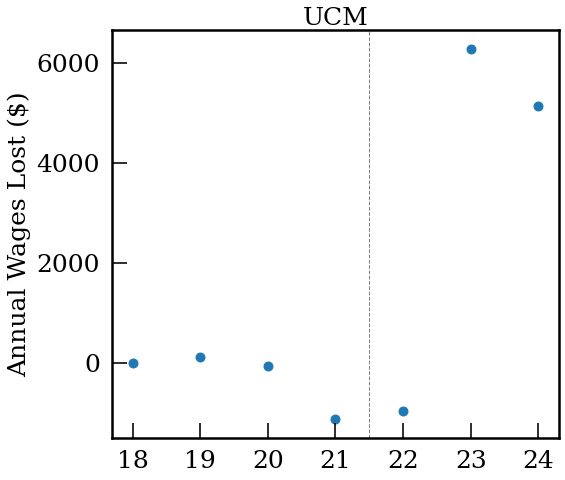

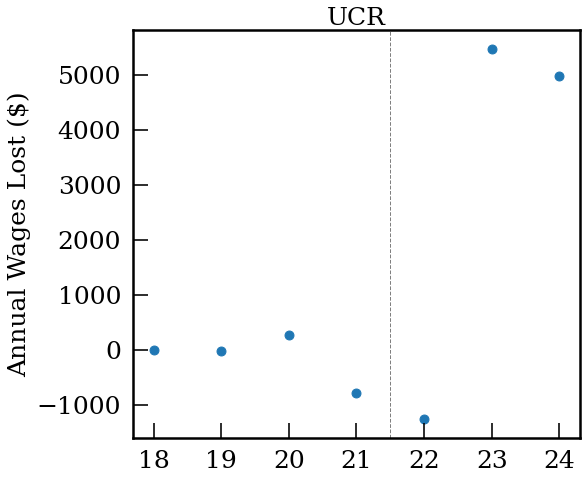

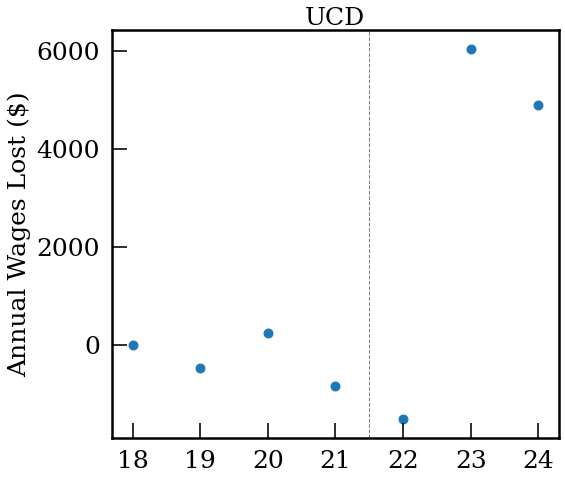

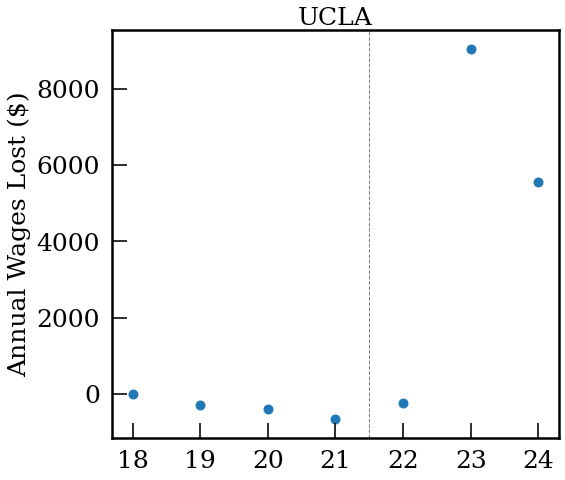

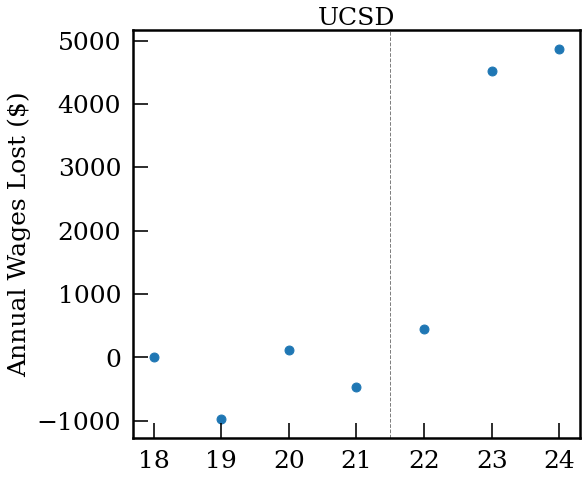

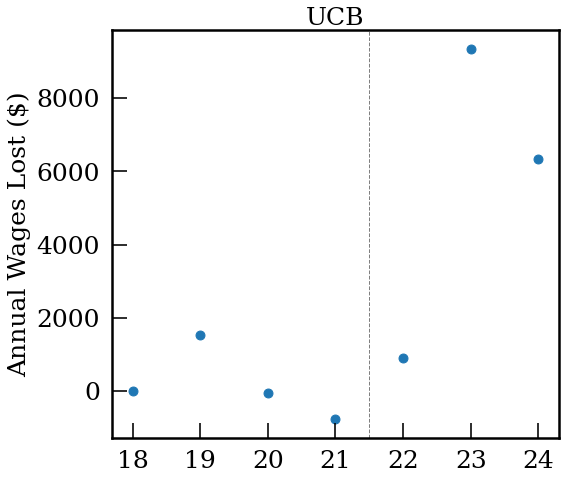

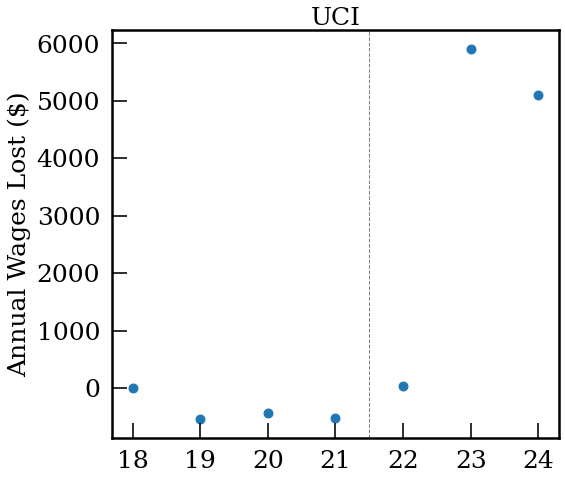

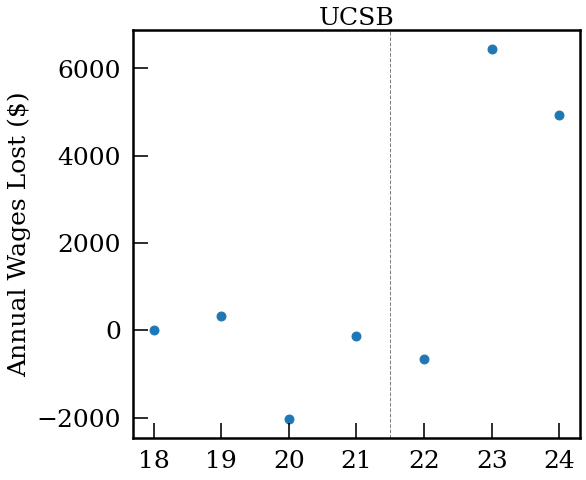

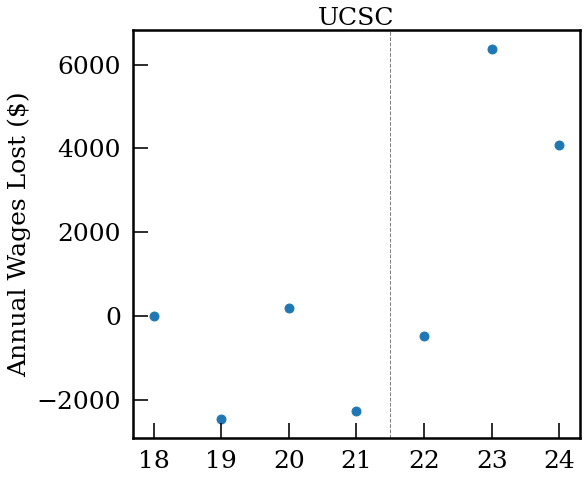

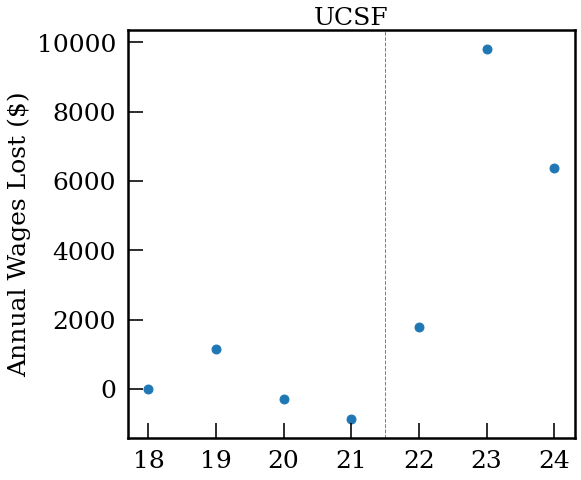

In [6]:
#annual loss in annual wages starting from 2018
for key in campuses: 
    df = data_12mo[key]
    df = df.loc[df["year"]<=2024]
    tix = df['year'].to_numpy()
    tix = np.asarray([(item[-2:]) for item in tix.astype(str)], dtype=int)
    plt.figure()
    plt.scatter(tix, df['dolRealWageChange'],s=80)
    plt.xticks(tix)
    plt.ylabel("Annual Wages Lost ($)")
    plt.axvline(x=21.5, c='gray', ls='--', lw=1)
    plt.title(key)

UCM :          -6.6 %   $ -1860
UCR :          -5.8 %   $ -1639
UCD :          -8.3 %   $ -2340
UCLA :          -5.3 %   $ -1495
UCSD :          -3.2 %   $ -896
UCB :          5.5 %   $ 1571
UCI :          -4.9 %   $ -1391
UCSB :          -8.3 %   $ -2348
UCSC :          -16.3 %   $ -4612
UCSF :          5.9 %   $ 1667


Text(0.5, -0.05, 'Average across all campuses=  -$1334')

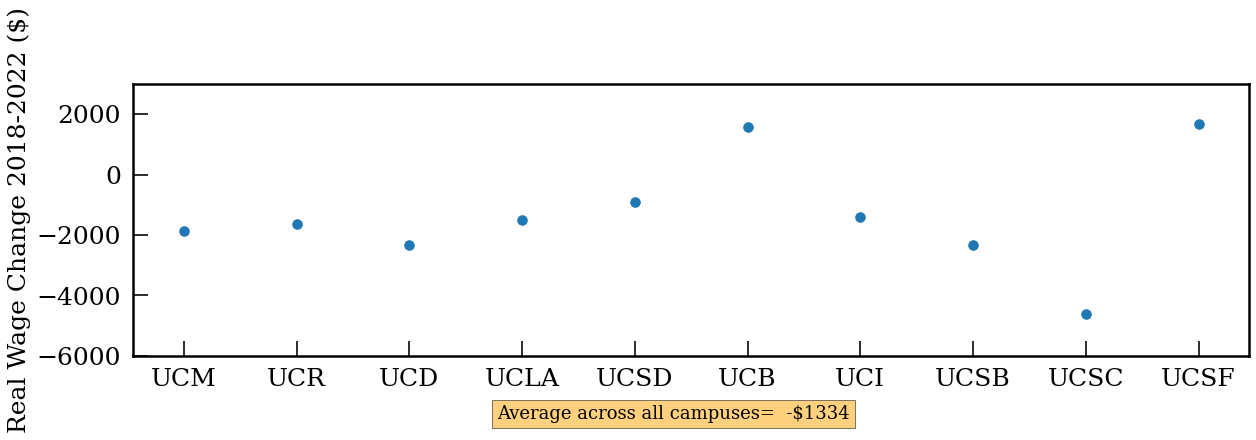

In [7]:
#How much do we lose in real wages for 2022 compared to 2018? 
dolChange_list = []
"""
for key in campuses:
    df = data_12mo[key]
    wage_2018 = float(df["wages"].loc[df["year"]==2018])
    rent_2018 = float(df["2br"].loc[df["year"]==2018])
    rentBurden_2018 = rent_2018/wage_2018
    wage_2022 = float(df["wages"].loc[df["year"]==2022])
    rent_2022 = float(df["2br"].loc[df["year"]==2022])
    wage_percChange = wage_2022/wage_2018 - 1
    rent_percChange = rent_2022/rent_2018 - 1
    cpi_change = (1+df["cpi"].loc[(df["year"]>2018) & (df["year"]<=2022) ]).to_numpy().prod() - 1

    percChangeWrt2018 = wage_percChange -  ((rentBurden_2018 * rent_percChange) + ((1-rentBurden_2018) * cpi_change  ))
    dolChange = percChangeWrt2018 * wage_2018
    print(key,":         ", round(percChangeWrt2018*100, 1), "%   $",  int(dolChange*12),"   " ,cpi_change)
    dolChange_list.append(dolChange*12)
    #wage_2018[0]

"""
#not sure why the above method and the one below are giving (slightly) different results..... need to debug!
for key in campuses:
    df = data_12mo[key]
    df = df.loc[df["year"] <=2022]
    percChangeWrt2018 = (1+df["percRealWageChange"]).to_numpy().prod() - 1
    dolChange = percChangeWrt2018*df["wages"].iloc[0]
    dolChange_list.append(dolChange*12)
    print(key,":         ", round(percChangeWrt2018*100, 1), "%   $",  int(dolChange*12))

plt.figure(figsize=(20,5))
plt.scatter(campuses, dolChange_list, s=90)
plt.ylim([-6000,3000])
plt.ylabel("Real Wage Change 2018-2022 ($)")
plt.figtext(0.5, -0.05, "Average across all campuses=  -$" + str(-1*int(np.mean(dolChange_list)) ), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


In [8]:
#cumulative losses for 2018-2022 (inclusive)
cum_losses_list =[]
end_year = 2024
for key in campuses:
    df = data_12mo[key]
    df = df.loc[df["year"] <=end_year]
    cum_loss = df["dolRealWageChange"].sum()
    cum_losses_list.append(cum_loss)
    print(key,":         $", round(cum_loss, 1))

UCM :         $ 9393.6
UCR :         $ 8653.1
UCD :         $ 8375.1
UCLA :         $ 13033.9
UCSD :         $ 8521.2
UCB :         $ 17321.7
UCI :         $ 9560.7
UCSB :         $ 8886.0
UCSC :         $ 5471.7
UCSF :         $ 18005.5


In [9]:
#inflation and rent adjusted % increase in income
for y_i in [2018,2021]:
    print("relative to {}".format(y_i))
    print("------------------")
    cont_change_list = []
    for key in campuses:
        df = data_12mo[key]
        df = df.loc[(df['year'] > y_i)]

        temp_array = 1+df["percRealWageChange"].to_numpy()
        cont_change = int((np.prod(temp_array)-1) * 100)
        cont_change_list.append(cont_change)

        print(key,":",cont_change,"%" )
    print('average :',np.mean(cont_change_list),'%\n')

relative to 2018
------------------
UCM : 26 %
UCR : 23 %
UCD : 22 %
UCLA : 37 %
UCSD : 23 %
UCB : 56 %
UCI : 26 %
UCSB : 23 %
UCSC : 10 %
UCSF : 58 %
average : 30.4 %

relative to 2021
------------------
UCM : 30 %
UCR : 26 %
UCD : 26 %
UCLA : 43 %
UCSD : 29 %
UCB : 52 %
UCI : 33 %
UCSB : 31 %
UCSC : 30 %
UCSF : 58 %
average : 35.8 %



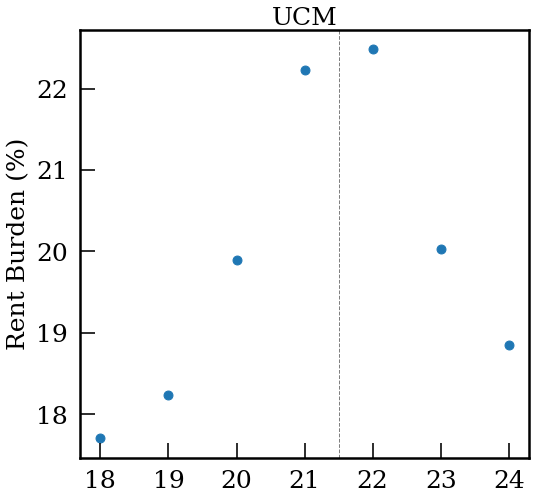

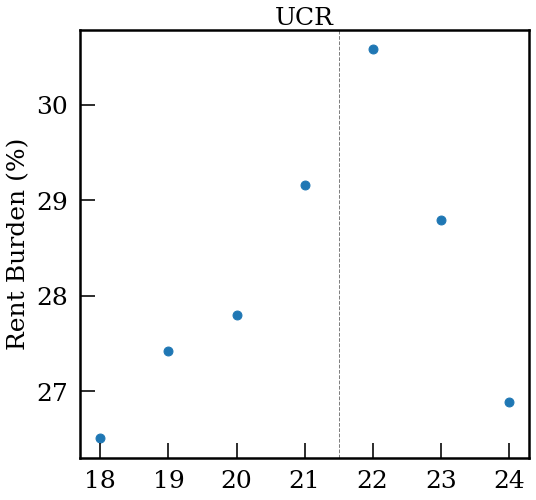

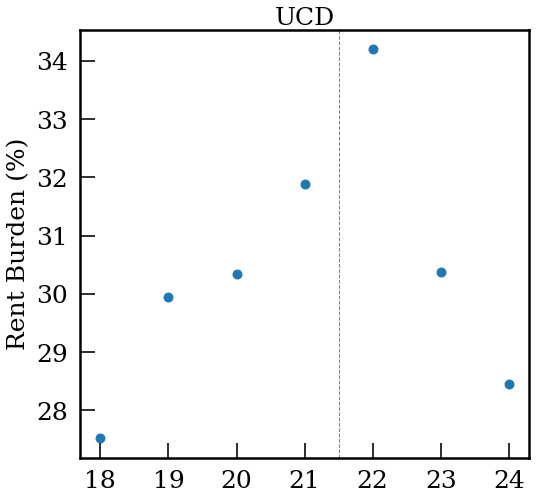

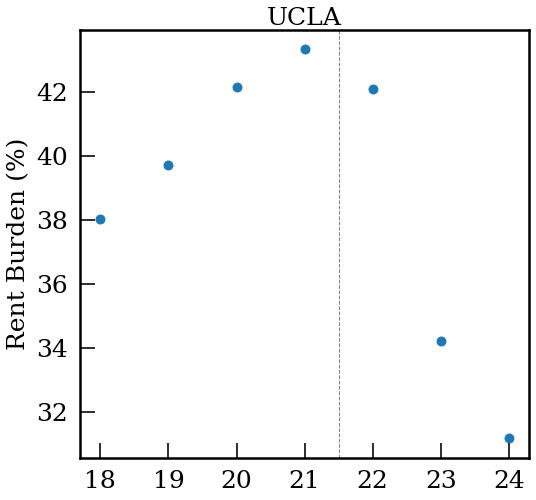

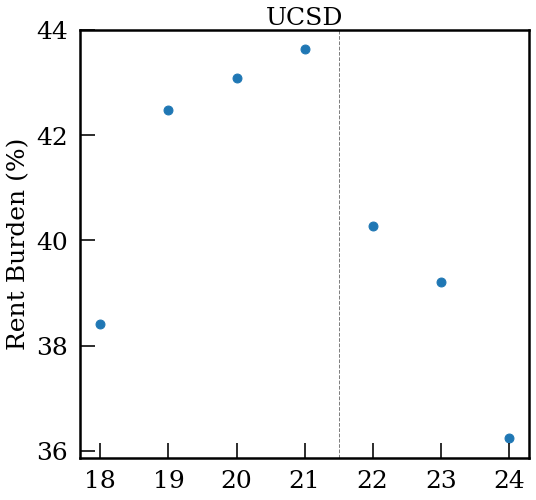

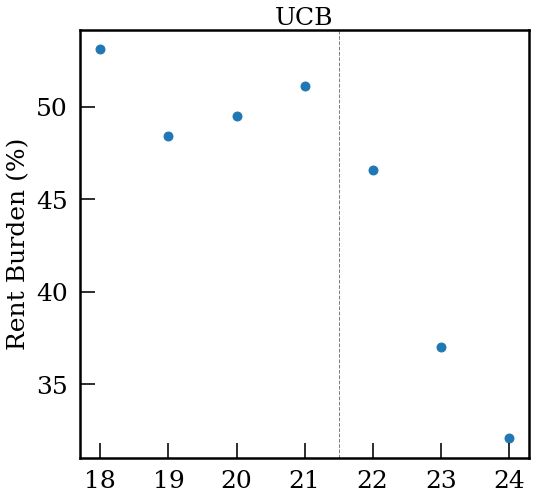

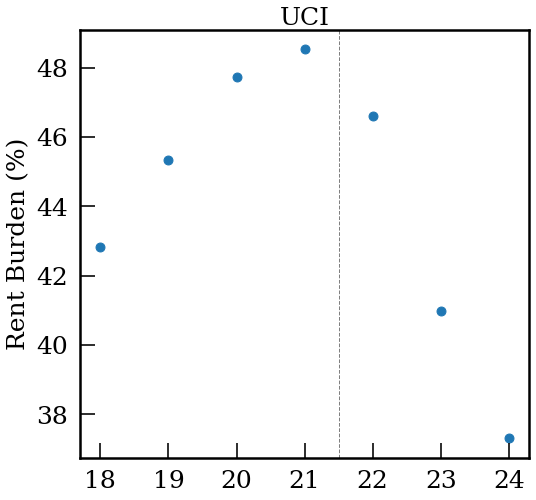

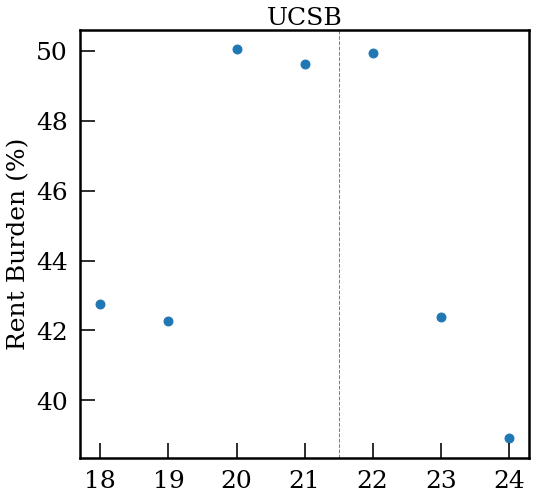

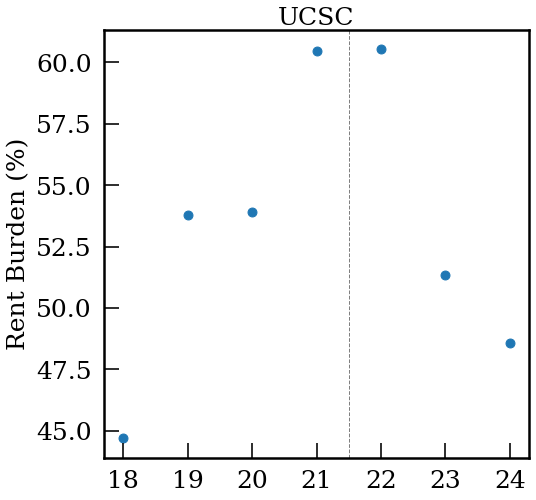

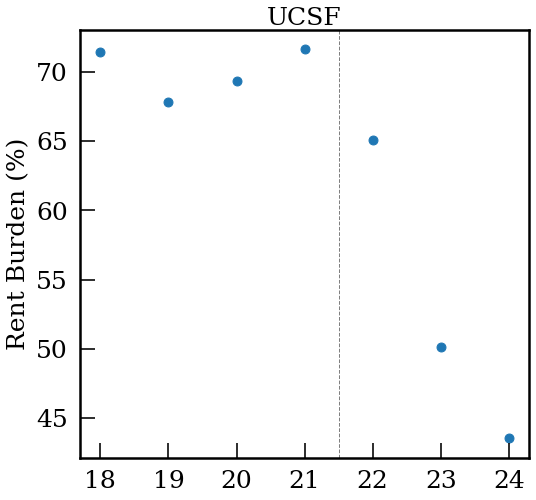

In [10]:
#rent burden over time, each campus plotted separately
for key in campuses:
    df_12mo = data_12mo[key]
    if prop == "UC120222":
        df_9mo = data_9mo[key]
    tix = df_12mo['year'].to_numpy()
    tix = np.asarray([(item[-2:]) for item in tix.astype(str)], dtype=int)
    plt.figure()
    plt.scatter(tix, df_12mo['rentBurden']*100,s=80, label = "12 month pay")
    if prop == "UC120222":
        plt.scatter(tix, df_9mo['rentBurden']*100,s=80, label = "9 month pay")
    plt.xticks(tix)
    plt.ylabel("Rent Burden (%)")
    plt.axvline(x=21.5, c='gray', ls='--', lw=1)
    plt.title(key)
    plt.tight_layout()
#     plt.savefig("./RB_{}.png".format(key))
#     plt.legend(frameon=True)

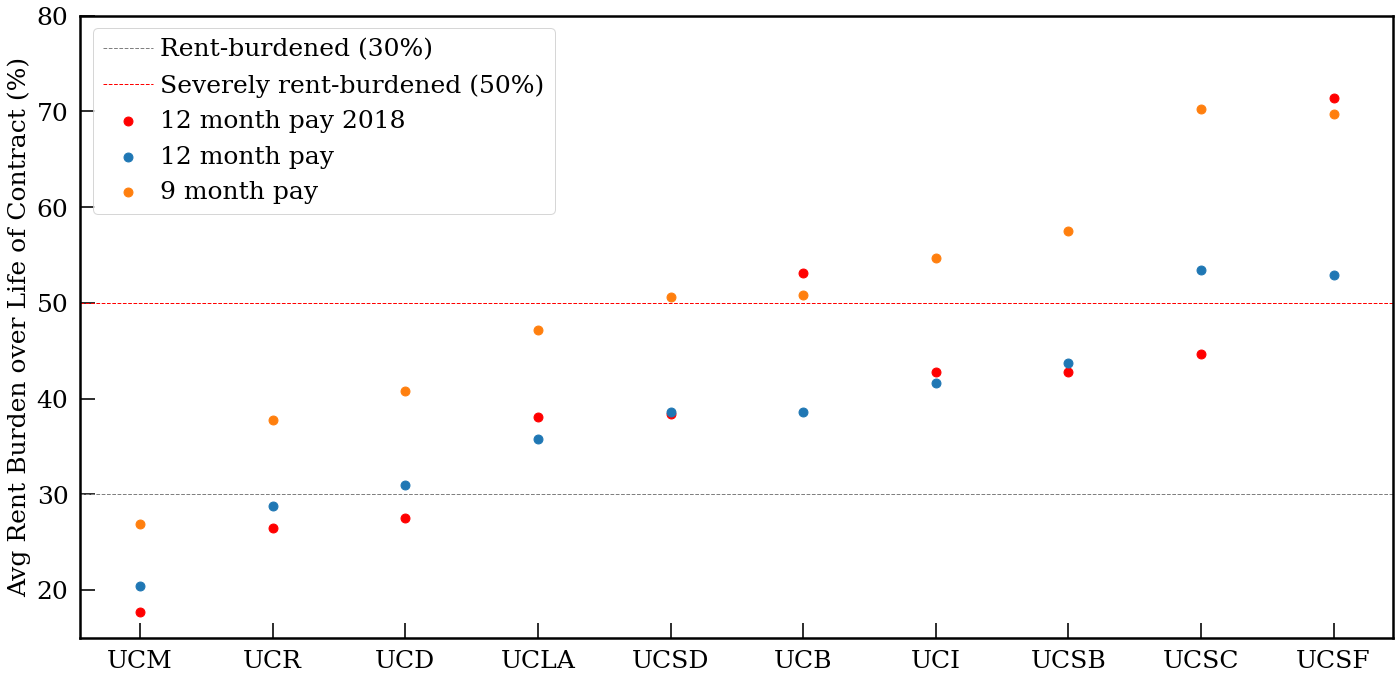

In [11]:
def timeseries_rent_burden(my_data):
    RB = []
    for t in data_12mo['UCM']["year"].to_numpy():
        RB_t = []
        for key in campuses:
            df = my_data[key]
            df = df.loc[(df['year'] == t)] #get data only at given year
            RB_t.append( df["rentBurden"].values[0]*100 )
        RB.append(RB_t)
    return np.array(RB)

#define time range for plotting
yr_i = 2022
yr_f = 2024
yr_i_idx = data_12mo['UCM']["year"][data_12mo['UCM']["year"]==yr_i].index[0]
yr_f_idx = data_12mo['UCM']["year"][data_12mo['UCM']["year"]==yr_f].index[0]

#whether to plot the average rent-burdens or timeseries of data
plot_timeseries = False

RB_12mo = timeseries_rent_burden(data_12mo)
avgRB_12mo = np.mean(RB_12mo[yr_i_idx:yr_f_idx+1], axis=0)
if prop in props_9mo:
    RB_9mo = timeseries_rent_burden(data_9mo)
    avgRB_9mo = np.mean(RB_9mo[yr_i_idx:yr_f_idx+1], axis=0)

plt.figure(figsize=(20,10))
plt.scatter(campuses, RB_12mo[0], s=80, c='red', label="12 month pay {}".format(2018))
if plot_timeseries:
    cmap_12mo = cm.get_cmap('Blues', (yr_f-yr_i+2) )
    cmap_9mo = cm.get_cmap('Oranges', (yr_f-yr_i+2) )
    for t_i, i in enumerate(np.arange(yr_i_idx,yr_f_idx+1)):
        plt.scatter(campuses, RB_12mo[i], s=80, c=cmap_12mo(t_i+1), label="12 month pay {}".format(yr_i+t_i))
        if prop in props_9mo:
            plt.scatter(campuses, RB_9mo[i], s=80, c=cmap_9mo((t_i+1)), label="9 month pay {}".format(yr_i+t_i))
        plt.ylabel("Rent Burden (%)")
else:
    plt.scatter(campuses, avgRB_12mo, s=80, label="12 month pay")
    if prop in props_9mo:
        plt.scatter(campuses, avgRB_9mo, s=80, label="9 month pay")
    plt.ylabel("Avg Rent Burden over Life of Contract (%)")

plt.axhline(y=30,c='gray', ls='--', lw=1, label = "Rent-burdened (30%)")
plt.axhline(y=50,c='red', ls='--', lw=1, label = "Severely rent-burdened (50%)")
plt.ylim([15,80])
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig("./RB.png")

The standard deviation in rent burden change is 9.814416897649991
The range of rent burden change is 31.77341075159717


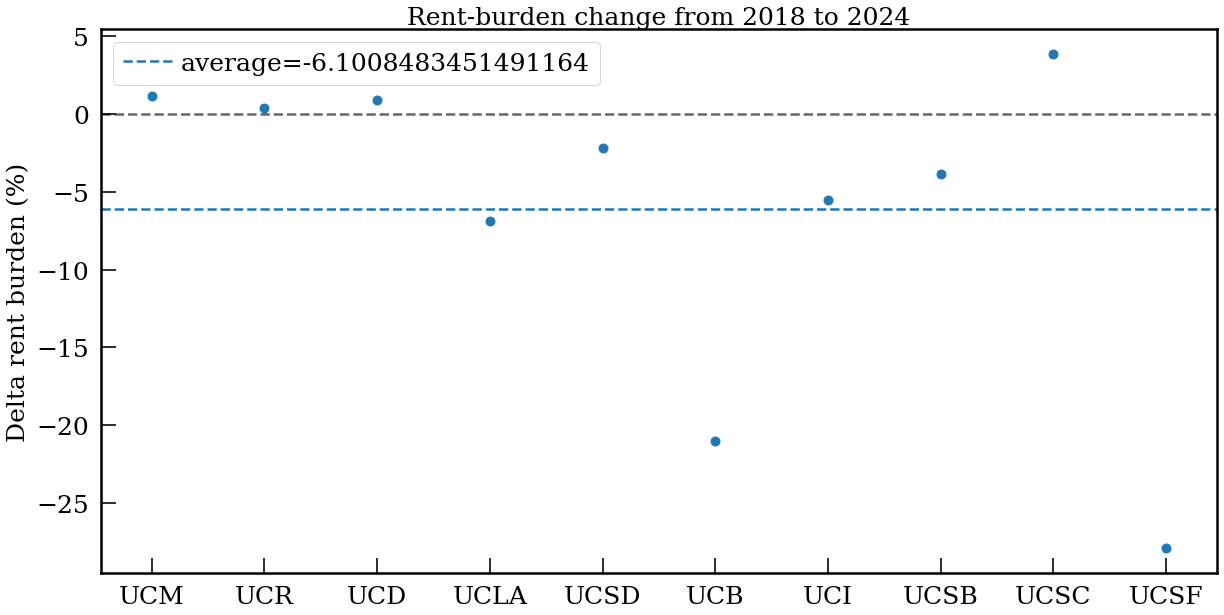

In [12]:
#difference in rent burden between two years
yr_i = 2018
yr_f = 2024
yr_i_idx = data_12mo['UCM']["year"][data_12mo['UCM']["year"]==yr_i].index[0]
yr_f_idx = data_12mo['UCM']["year"][data_12mo['UCM']["year"]==yr_f].index[0]
del_RB = np.array(RB_12mo[yr_f_idx]) - np.array(RB_12mo[yr_i_idx])
plt.figure(figsize=(20,10))
plt.scatter(campuses, del_RB, s=80)
plt.axhline(np.mean(del_RB), label='average={}'.format(np.mean(del_RB)), ls='--')
plt.axhline(0, ls='--', c='black', alpha=0.6)
# plt.axhline(-5, ls='--', c='black', alpha=0.6)
plt.ylabel("Delta rent burden (%)")
plt.title("Rent-burden change from {} to {}".format(yr_i,yr_f))
plt.legend(frameon=True)
print("The standard deviation in rent burden change is {}".format(np.std(del_RB)))
print("The range of rent burden change is {}".format(max(del_RB)-min(del_RB)))

The standard deviation in rent burden change is 9.814416897649991
The range of rent burden change is 31.77341075159717


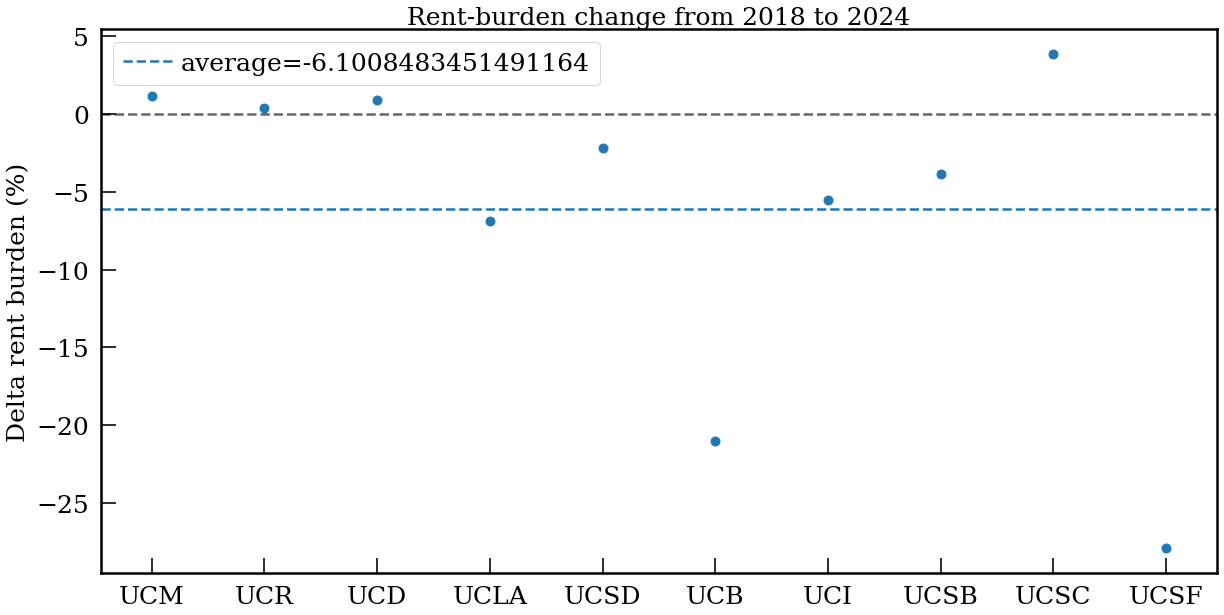

In [13]:
#difference in rent burden between two years
yr_i = 2018
yr_f = 2024
yr_i_idx = data_12mo['UCM']["year"][data_12mo['UCM']["year"]==yr_i].index[0]
yr_f_idx = data_12mo['UCM']["year"][data_12mo['UCM']["year"]==yr_f].index[0]
del_RB = np.array(RB_12mo[yr_f_idx]) - np.array(RB_12mo[yr_i_idx])
plt.figure(figsize=(20,10))
plt.scatter(campuses, del_RB, s=80)
plt.axhline(np.mean(del_RB), label='average={}'.format(np.mean(del_RB)), ls='--')
plt.axhline(0, ls='--', c='black', alpha=0.6)
# plt.axhline(-5, ls='--', c='black', alpha=0.6)
plt.ylabel("Delta rent burden (%)")
plt.title("Rent-burden change from {} to {}".format(yr_i,yr_f))
plt.legend(frameon=True)
print("The standard deviation in rent burden change is {}".format(np.std(del_RB)))
print("The range of rent burden change is {}".format(max(del_RB)-min(del_RB)))